In [1]:
import pydicom
import os
import numpy as np
import cv2
import pydicom
from glob import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

### From directory make csv files with labels

In [54]:
def process_label_df(df):
    df['path'] = df.apply(lambda row: '/'.join([str(row['home_folder_name']), str(row['folder_name']), str(row['file_name']).split('.')[0]]), axis=1)
    return df

In [55]:
def create_label_df(amy, non_amy):
    non_amy['home_folder_name'] = 'Tahseen'
    processed_amy = process_label_df(amy)
    processed_non_amy = process_label_df(non_amy)
    label_df = pd.concat([processed_amy, processed_non_amy], axis=0).reset_index()
    return label_df

In [40]:
def find_all_paths(df, addresses):
    all_path = []
    all_path.extend([i.split(addresses[0])[-1] for i in glob(os.path.join(addresses[0], '*/**/*'))])
    all_path.extend([('/').join(i.split('/')[-3:]) for i in glob(os.path.join(addresses[1], '*/**/*'))])
    return df[df['path'].isin(all_path)]


In [41]:
def filter_basedOn_labels(label_df):
    return label_df[~label_df['label'].isna()].reset_index(drop= True)

In [ ]:
def create_csv(label_df, parent_dir, amy_folders):
    data_dict = {
        'path': [], 
        'label': [], 
        'disease': [], 
        'sample_spacing': [], 
        'start': [], 
        'end': [],
        'home_folder_name': []
    }

    for i, row in label_df.iterrows():
        try:
            if row['home_folder_name'] not in amy_folders:
                original_path = parent_dir[0]
                imgs = glob(os.path.join(original_path, row['path'], '*'))
            else:
                original_path = parent_dir[1]
                imgs = glob(os.path.join(original_path, row['path'], '*'))
            
            if len(imgs) < 10:
                continue

            sorted_imgs = sorted([
                int(os.path.basename(add).split('_')[-1].rstrip('.png')) 
                for add in imgs
            ])
            
            start, end = int(sorted_imgs[0]), int(sorted_imgs[-1])
            selected_frames, retstep = np.linspace(start, end, num=10, retstep=True)

            disease = 1 if row['home_folder_name'] in amy_folders else 0
            label = row['label']

            data_dict['path'].append(row['path'])
            data_dict['label'].append(label)
            data_dict['disease'].append(disease)
            data_dict['sample_spacing'].append(retstep)
            data_dict['start'].append(start)
            data_dict['end'].append(end)


        except Exception as e:
            print(f"⚠️ Error on row {i}: {e}")
            continue

    # Final length check
    lengths = [len(v) for v in data_dict.values()]
    if len(set(lengths)) != 1:
        raise ValueError("❌ Mismatched lengths in data_dict fields.")

    return pd.DataFrame(data_dict)


In [43]:
def filter_views(df, items):
    contrast_mapping = {
        'Contrast-4ch': 'Contrast-Apical-4ch',
        'Apical-4ch-contrast': 'Contrast-Apical-4ch',

        'Contrast-3ch': 'Contrast-Apical-3ch',
        'Apical-3ch-contrast': 'Contrast-Apical-3ch',

        'Contrast-2ch': 'Contrast-Apical-2ch',
        'Apical-2ch-contrast': 'Contrast-Apical-2ch',

        'PLAX-contrast': 'Contrast-PLAX',
        'Other-contrast': 'Contrast-Other',
    }

    def filter_item(x):
        x = x.rstrip()
        parts = x.split('-')
        # Remove any suffix part that matches known suffixes
        filtered = [p for p in parts if p.lower() not in items]
        return '-'.join(filtered)

    df['label'] = df['label'].apply(filter_item)
    df['label'] = df['label'].replace(contrast_mapping)
    df = df[~df['label'].str.contains('strain', case=False, na=False)]
    df = df[df['label'] != 'PSAX-ves-base']

    # df = df[df['label'] != 'Other']
    df = df[df['label'] != 'CW']
    df = df[df['label'] != 'Contrast-Other'] #constrast blood pool, different image from apical 4ch
    df = df[df['label'] != 'Contrast-PLAX']
    # df = df[df['label'] != '2ch']
  

    return df

In [ ]:
amy_folders = ['TTE', 'US_guided_biopsy', 'cardiac_stress_study']

file_path = '/home/shokoo/EchoView/view_classification/csv_files'
data_path_non_amy = '/home/shokoo/EchoView/Datasets/non_amyloid/processed/'
data_path_amy = '/home/shokoo/EchoView/Datasets/amyloid/processed/'
# addresses = pd.read_csv('/home/shokoo/EchoView/view_classification/csv_files/data_address.csv')
amy_labels = pd.read_csv(os.path.join(file_path, 'Amyloid_echo_view_labels - Sheet1.csv'))
non_amy_labels = pd.read_csv(os.path.join(file_path, 'NEW_Tahseen_echo_view_labels - Sheet1.csv'))

parent_dir = [data_path_non_amy, data_path_amy]

label_df = create_label_df(amy_labels, non_amy_labels)
valid_label_df = find_all_paths(label_df, parent_dir) # important that non amy should come first in parent dir list
print(len(label_df) - len(valid_label_df))
filtered_all_paths = filter_basedOn_labels(valid_label_df)
print(len(valid_label_df) - len(filtered_all_paths), 'studies are unlabeled.')

df = create_csv(filtered_all_paths, parent_dir, amy_folders)

df = filter_views(df, [ 'd', '2d'])

df['patient_id'] = df['path'].apply(lambda x:x.split('/')[-2])
# # filtered_all_paths

In [76]:
df.to_csv('all_labeled_data.csv', index=False)

### from csv file split stratifed data patient-wise on view labels 

In [77]:
def group_patient(df): # Group view labels per patient
    patient_df = df.groupby('patient_id').agg({
        'label': lambda x: list(set(x)),  # Unique views per patient
        'disease': 'first'  # Assumes consistent health status per patient
    }).reset_index()
    return patient_df

In [78]:
def encoding(patient_df):
    # One-hot encode the multi-label views
    mlb = MultiLabelBinarizer()
    view_matrix = mlb.fit_transform(patient_df['label'])

    # Combine views and health status into stratification features
    stratify_features = np.hstack([view_matrix, patient_df[['disease']].values])
    return stratify_features

In [79]:
def update_df_path_column(split_map):
    results = []
    for split_name, df in split_map.items():
        df['parent_dir'] = df['path'].apply(lambda x:x.split('/')[0])
        df.path = df['path'].str.replace(r'^[^/]+', f'{split_name}', regex=True)
        results.append(df)
    return results[0], results[1], results[2]

In [80]:
def create_split(patient_df, stratify_features, df):
    # Initialize splitter
    mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Split into train+val vs test (say 80-20 first)
    train_val_idx, test_idx = next(mskf.split(patient_df['patient_id'], stratify_features))

    # Apply another split to train_val for train vs val (say 75-25)
    train_idx, val_idx = next(
        mskf.split(
            patient_df.iloc[train_val_idx]['patient_id'],
            stratify_features[train_val_idx]
        )
    )
    # Get patient IDs
    train_patients = patient_df.iloc[train_val_idx].iloc[train_idx]['patient_id'].tolist()
    val_patients = patient_df.iloc[train_val_idx].iloc[val_idx]['patient_id'].tolist()
    test_patients = patient_df.iloc[test_idx]['patient_id'].tolist()

    train_df = df[df['patient_id'].isin(train_patients)]
    val_df = df[df['patient_id'].isin(val_patients)]
    test_df = df[df['patient_id'].isin(test_patients)]

    split_map = {
        'train': train_df,
        'val': val_df,
        'test': test_df
    }

    train_df, val_df, test_df = update_df_path_column(split_map)

    train_df.drop(['patient_id'], axis=1, inplace=True)
    val_df.drop(['patient_id'], axis=1, inplace=True)
    test_df.drop(['patient_id'], axis=1, inplace=True)


    return train_df, val_df, test_df

In [81]:
def make_csv(df , df_name = 'df', dest_dir=''):
    df.to_csv(os.path.join(dest_dir,f'{df_name}.csv'), index=False)
    print(f"saved {df_name} csv.")

In [82]:
def plot_label_and_disease_distribution(train_df, val_df, test_df, 
                                        view_label_col='view_label', 
                                        disease_col='health_status',
                                        threshold=0.05):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sets = {'Train': train_df, 'Validation': val_df, 'Test': test_df}

    # ============================
    # 1. View Label Distribution
    # ============================

    # Collect view label counts
    view_dist = {}
    for name, df in sets.items():
        view_dist[name] = df[view_label_col].value_counts()

    view_df = pd.DataFrame(view_dist).fillna(0).astype(int)
    view_df_norm = view_df.div(view_df.sum(axis=0), axis=1)

    # Plot absolute counts
    plt.figure(figsize=(14, 6))
    view_df.plot(kind='bar', figsize=(14, 6))
    plt.title('View Label Distribution (Absolute Counts)')
    plt.xlabel('View Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plot normalized proportions
    plt.figure(figsize=(14, 6))
    view_df_norm.plot(kind='bar', figsize=(14, 6))
    plt.title('View Label Distribution (Normalized)')
    plt.xlabel('View Label')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Highlight underrepresented view labels
    underrepresented_views = (view_df_norm < threshold).any(axis=1)
    if underrepresented_views.any():
        print("⚠️ Underrepresented view labels (proportion < {:.0%} in any set):".format(threshold))
        print(view_df_norm[underrepresented_views])
    else:
        print("✅ All view labels are well represented.")

    # ============================
    # 2. Disease Label Distribution
    # ============================

    # Collect disease status counts
    disease_dist = {}
    for name, df in sets.items():
        disease_dist[name] = df[disease_col].value_counts()

    disease_df = pd.DataFrame(disease_dist).fillna(0).astype(int)
    disease_df_norm = disease_df.div(disease_df.sum(axis=0), axis=1)

    # Plot absolute counts
    plt.figure(figsize=(8, 4))
    disease_df.plot(kind='bar', figsize=(8, 4))
    plt.title('Disease Status Distribution (Absolute Counts)')
    plt.xlabel('Disease Status')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plot normalized proportions
    plt.figure(figsize=(8, 4))
    disease_df_norm.plot(kind='bar', figsize=(8, 4))
    plt.title('Disease Status Distribution (Normalized)')
    plt.xlabel('Disease Status')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Highlight underrepresented disease labels
    underrepresented_disease = (disease_df_norm < threshold).any(axis=1)
    if underrepresented_disease.any():
        print("⚠️ Underrepresented disease labels (proportion < {:.0%} in any set):".format(threshold))
        print(disease_df_norm[underrepresented_disease])
    else:
        print("✅ All disease labels are well represented.")


<Figure size 1400x600 with 0 Axes>

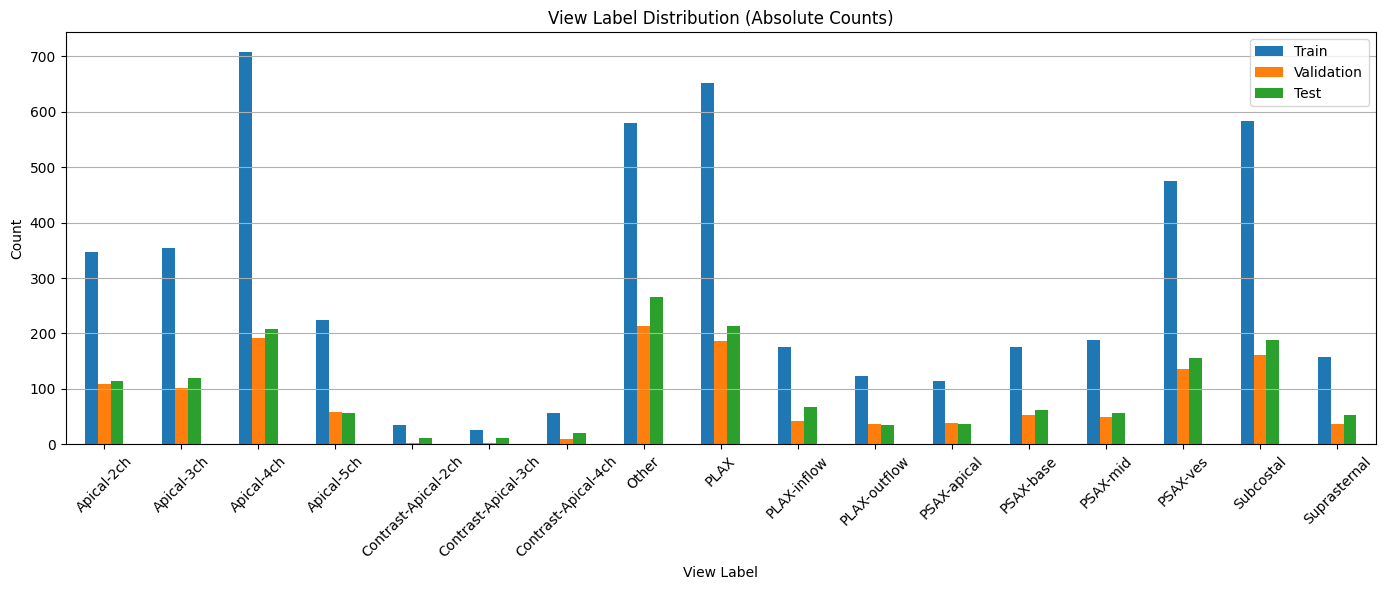

<Figure size 1400x600 with 0 Axes>

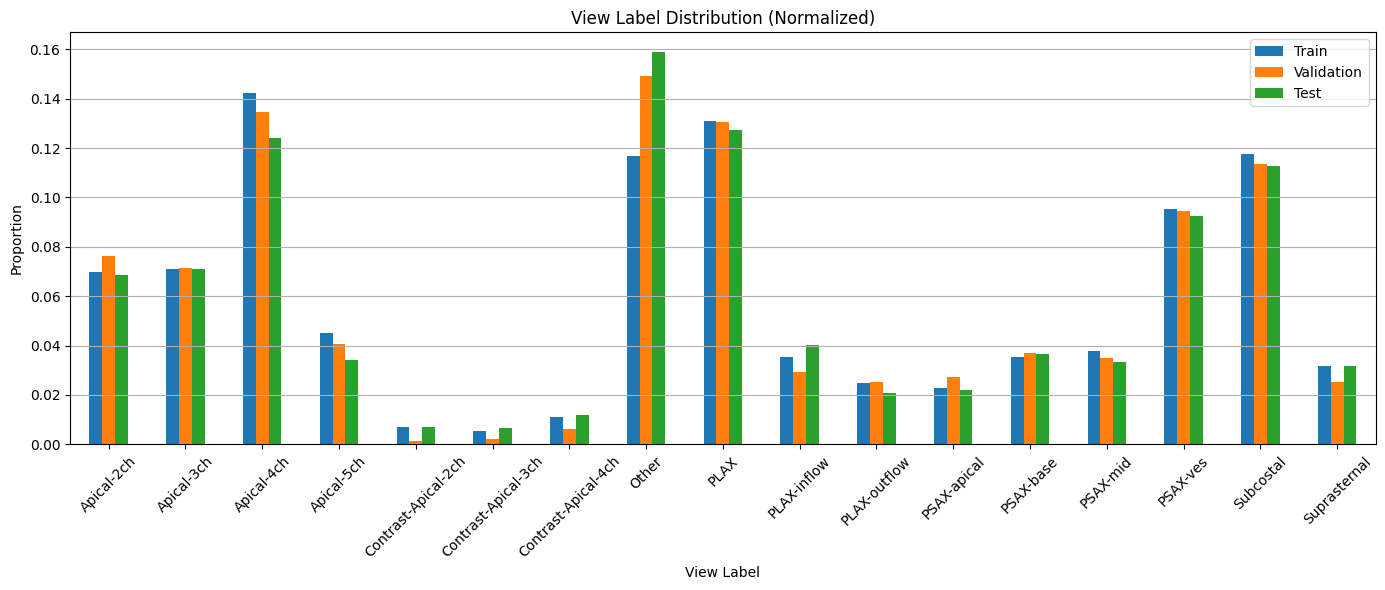

⚠️ Underrepresented view labels (proportion < 5% in any set):
                        Train  Validation      Test
label                                              
Apical-5ch           0.045226    0.040645  0.034050
Contrast-Apical-2ch  0.007035    0.001402  0.007168
Contrast-Apical-3ch  0.005226    0.002102  0.006571
Contrast-Apical-4ch  0.011256    0.006307  0.011947
PLAX-inflow          0.035176    0.029432  0.040024
PLAX-outflow         0.024724    0.025228  0.020908
PSAX-apical          0.022915    0.027330  0.022103
PSAX-base            0.035377    0.037141  0.036440
PSAX-mid             0.037789    0.035039  0.033453
Suprasternal         0.031558    0.025228  0.031661


<Figure size 800x400 with 0 Axes>

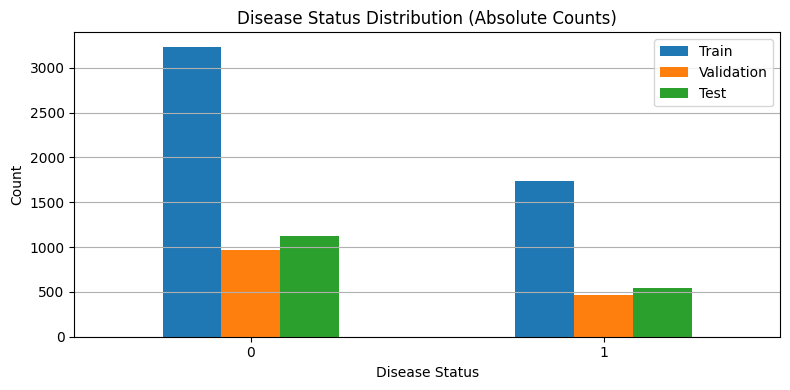

<Figure size 800x400 with 0 Axes>

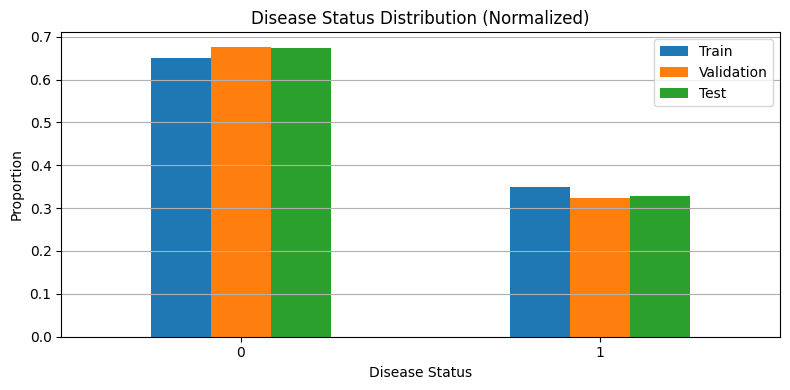

✅ All disease labels are well represented.


In [92]:
plot_label_and_disease_distribution(train_df, val_df, test_df, 
                                    view_label_col='label', 
                                    disease_col='disease')

In [93]:
patient_df = group_patient(df)
stratify_features = encoding(patient_df)
train_df, val_df, test_df = create_split(patient_df, stratify_features, df)
make_csv(train_df, 'train')
make_csv(val_df, 'val')
make_csv(test_df, 'test')

saved train csv.
saved val csv.
saved test csv.


/tmp/ipykernel_4559/2875879677.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parent_dir'] = df['path'].apply(lambda x:x.split('/')[0])
/tmp/ipykernel_4559/2875879677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.path = df['path'].str.replace(r'^[^/]+', f'{split_name}', regex=True)
/tmp/ipykernel_4559/2875879677.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

### Organizing directory for train/val/test splits

In [ ]:
def copy_files_by_split(train_df, val_df, test_df,
                        amy_folders,
                        source_root,
                        filepath_col = 'path',
                        output_parent_folder = '/home/shokoo/EchoView/Datasets',
                        output_root='dataset-17view'):
    # Mapping from df to split name
    split_map = {
        'train': train_df,
        'val': val_df,
        'test': test_df
    }

    for split, df in split_map.items():
        print(f"\n Copying {len(df)} files to '{split}' folder...")
        for _, row in tqdm(df.iterrows(), total=len(df), desc=f'Copying {split}'):
            rel_path = row[filepath_col]  # relative path to the file
            if rel_path.split('/')[0] in amy_folders:
                src_path = os.path.join(source_root[1], rel_path)
            else:
                src_path = os.path.join(source_root[0], rel_path)
                rel_path = '/'.join(rel_path.split('/')[1:]) 
            dest_path = os.path.join(output_parent_folder, output_root, split, rel_path)

            if not os.path.exists(src_path):
                print(f"⚠️ Source folder not found: {src_path}")
                continue

            # Create destination folder if it doesn't exist
            os.makedirs(dest_path, exist_ok=True)

            # Copy all files from src_folder to dest_folder
            for filename in os.listdir(src_path):
                src_file = os.path.join(src_path, filename)
                dest_file = os.path.join(dest_path, filename)

                if os.path.isfile(src_file):
                    try:
                        shutil.copy2(src_file, dest_file)
                    except Exception as e:
                        print(f" Error copying {src_file}: {e}")

        print(f" Done copying for '{split}'.")

In [7]:
train_df = pd.read_csv(os.path.join(file_path, 'train_original.csv'))
val_df = pd.read_csv(os.path.join(file_path, 'val_original.csv'))
test_df = pd.read_csv(os.path.join(file_path, 'test_original.csv'))

In [8]:
import re 

split_map = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

def update_df_path_column(split_map):
    results = []
    for split_name, df in split_map.items():

        df.path = df.apply(lambda row: re.sub(r'^[^/]+', f"{row['parent_dir']}", row['path']), axis=1)
        results.append(df)
    return results[0], results[1], results[2]

train_df, val_df, test_df = update_df_path_column(split_map)

In [ ]:
copy_files_by_split(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    amy_folders=amy_folders,
    source_root=parent_dir,     # Folder where all files currently live
    filepath_col='path',         # Change if your column is named differently
                                # Folder where you want to organize into train/val/test
)


 Copying 4365 files to 'train' folder...


Copying train:  41%|████      | 1784/4365 [00:00<00:00, 17837.04it/s]

/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/10
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/100
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/101
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/102
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/103
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/104
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/105
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/11
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/15
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/-40uXj7VSHK4KVuHfAjiYQ/16
/home/shokoo/EchoView/Datasets/amy

Copying train:  83%|████████▎ | 3619/4365 [00:00<00:00, 18029.44it/s]

/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/48
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/49
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/56
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/59
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/63
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/64
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/65
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/66
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/67
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_EqYSqQNStOCDlCySL2vZw/75
/home/shokoo/EchoView/Datasets/amyloid/p

Copying train: 100%|██████████| 4365/4365 [00:00<00:00, 17638.17it/s]


/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/34
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/35
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/36
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/37
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/4
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/40
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/49
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/5
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/50
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/train/_fpOPq7mSyKI-q7AIVddew/52
/home/shokoo/EchoView/Datasets/amyloid/pro

Copying val: 100%|██████████| 1055/1055 [00:00<00:00, 16074.28it/s]


/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/10
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/11
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/12
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/17
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/18
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/2
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/21
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/24
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/25
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/val/0dZsM3pyQSGVR8kSVktutg/28
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17vi

Copying test: 100%|██████████| 1426/1426 [00:00<00:00, 18408.53it/s]

/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/10
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/11
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/13
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/14
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/17
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/2
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/20
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/21
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/22
/home/shokoo/EchoView/Datasets/amyloid/processed/dataset-17view/test/-8UKHE9bQ0u09nleXrwgBg/24
/home/shokoo/EchoView/Datasets/amyloid/processed/da